<a href="https://colab.research.google.com/github/hauduong05/Movie_Recommendation/blob/main/Collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

# Load data

In [ ]:
movies = pd.read_csv('/content/gdrive/MyDrive/movie/movies.csv', 
                     usecols=['movieId', 'title'], 
                     dtype={'movieId': 'int32', 'title': 'str'})
ratings = pd.read_csv('/content/gdrive/MyDrive/movie/ratings.csv', 
                      usecols=['userId', 'movieId', 'rating'], 
                      dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

# number of rating for every movie
nb_user_voted = ratings.groupby('movieId')['rating'].agg('count')
# number of rating given by every user
nb_movie_vote = ratings.groupby('userId')['rating'].agg('count')

In [ ]:
movies

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
62418,209157,We (2018)
62419,209159,Window of the Soul (2001)
62420,209163,Bad Poems (2018)
62421,209169,A Girl Thing (2001)


In [ ]:
ratings

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5
...,...,...,...
25000090,162541,50872,4.5
25000091,162541,55768,2.5
25000092,162541,56176,2.0
25000093,162541,58559,4.0


# Data analysis

1.00    81491.0
0.95     1503.4
0.90      413.0
0.85      152.0
0.80       68.0
0.75       36.0
0.70       22.0
0.65       14.0
Name: rating, dtype: float64

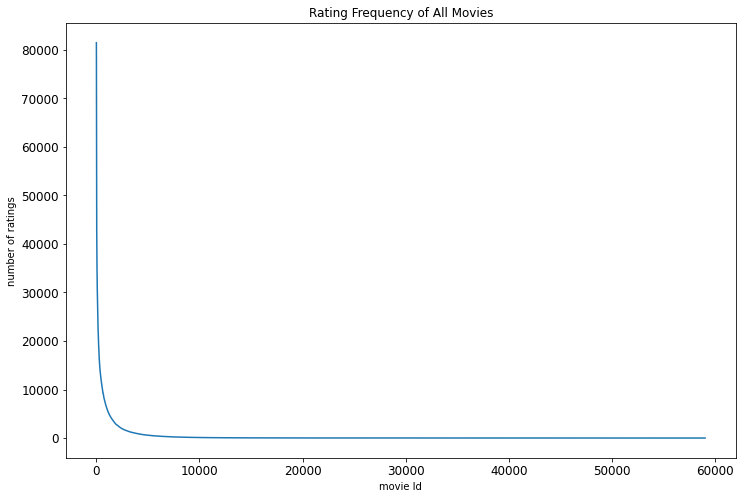

In [ ]:
# plot rating frequency of all movies
ax = nb_user_voted \
    .sort_values(ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

nb_user_voted.quantile(np.arange(1, 0.6, -0.05))

1.00    32202.0
0.95      554.0
0.90      353.0
0.85      258.0
0.80      202.0
0.75      162.0
0.70      134.0
0.65      112.0
0.60       97.0
0.55       82.0
0.50       71.0
0.45       61.0
0.40       53.0
0.35       47.0
Name: rating, dtype: float64

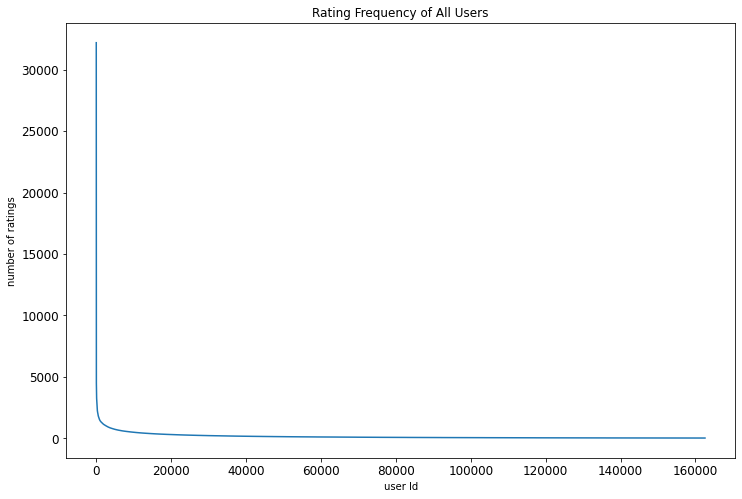

In [ ]:
# plot rating frequency of all movies
ax = nb_movie_vote \
    .sort_values(ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
# ax.axhline(y=threshold, color='r')
ax.set_ylabel("number of ratings")


nb_movie_vote.quantile(np.arange(1, 0.3, -0.05))

# Filter data

Only keep movies with number of rating > 50

In [ ]:
threshold = 50
popular_movies = list(set(nb_user_voted[nb_user_voted > threshold].index))
ratings = ratings[ratings['movieId'].isin(popular_movies)]

Only keep users with number of voting > 50

In [ ]:
threshold = 50
active_users = list(set(nb_movie_vote[nb_movie_vote > threshold].index))
ratings = ratings[ratings['userId'].isin(active_users)]

# Train model

Prepare train - test set

In [ ]:
train, test = train_test_split(ratings, test_size=0.01, shuffle=True, random_state = 21)

train = train.sort_values('userId')
train_index_by_user = train.copy().set_index('userId')
test = test.sort_values('userId')


train_users = list(train.groupby('userId')['rating'].agg('count').index)
train_items = list(train.groupby('movieId')['rating'].agg('count').index)
n_train_users = len(train_users)
n_train_movies = len(train_items)
n_train = train.shape[0]
train_userId = train['userId'].values
train_movieId = train['movieId'].values


Calculate means



In [ ]:
temp_means = train.groupby('movieId')['rating'].transform('mean')
train_rate = train['rating']-temp_means
means = pd.DataFrame({"movieId": train.movieId, "mean":temp_means}).drop_duplicates().set_index("movieId")


Create sparse matrix

In [ ]:
dict1 = dict(zip(train_users, [i for i in range(n_train_users)]))
dict2 = dict(zip(train_items, [i for i in range(n_train_movies)]))
userId_trans = []
movieId_trans = []

for i in range(n_train):
  userId_trans.append(dict1[train_userId[i]])
for i in range(n_train):
  movieId_trans.append(dict2[train_movieId[i]])

csr_dt = csr_matrix((train_rate, (movieId_trans, userId_trans)), (n_train_movies, n_train_users))

Calculate cosine-similarity matrix

In [ ]:
list_key = list(dict2.keys())
list_value = list(dict2.values())

corr_matrix = cosine_similarity(csr_dt, csr_dt)

# Make recommendation

## Make movie recommendation by movie name

In [ ]:
def get_movie_recommendation(movie_name):

  n_movie_get_recommend = 10
  movie_list = movies[movies['title'].str.contains(movie_name, na=False)]

  if len(movie_list):
    movie_idx = [0]
    for i in range(len(movie_list)):
      id = int(movie_list.iloc[i]['movieId'])
      if id in train_items:
        movie_idx[0] = id
        break
  
    movie_idx_trans = dict2[movie_idx[0]]
    sim = corr_matrix[movie_idx_trans]
    sim_idx = np.argsort(sim)[-(n_movie_get_recommend+1):]
    nn = sim[sim_idx]
    recommend = list(zip(sim_idx, nn))
    recommend.reverse()
    recommend = recommend[1:]

    recommend_frame = []
    for val in recommend:
      pos = list_value.index(val[0])
      movie_idx = list_key[pos]
      idx = movies[movies['movieId'] == movie_idx].index
      recommend_frame.append({'Title' : movies.iloc[idx]['title'].values[0], 'Similarity' : val[1]})

    df = pd.DataFrame(recommend_frame, index=range(1, n_movie_get_recommend+1))
    return df
  else:
    return 'No movies found. Please check your movie input'

In [ ]:
get_movie_recommendation('Toy Story')

,Title,Similarity
1,Toy Story 2 (1999),0.405366
2,"Monsters, Inc. (2001)",0.290770
3,Finding Nemo (2003),0.269808
4,Aladdin (1992),0.266527
5,"Lion King, The (1994)",0.264515
6,"Bug's Life, A (1998)",0.256979
7,Toy Story 3 (2010),0.245399
8,Shrek (2001),0.230446
9,"Incredibles, The (2004)",0.228499
10,Beauty and the Beast (1991),0.227117


## Make recommendation for user

In [ ]:
def predict(u, i, knn=5):
  u_rate_movie = train_index_by_user.loc[u]['movieId']
  u_rate_movie_trans = []
  for j in u_rate_movie:
    u_rate_movie_trans.append(dict2[j])
  u_rate_movie_trans = np.array(u_rate_movie_trans)
  u_trans = dict1[u]
  i_trans = dict2[i]
  sml = corr_matrix[i_trans][u_rate_movie_trans]
  nn = np.argsort(sml)[-knn:]
  nearest = sml[nn]
  r = csr_dt[u_rate_movie_trans[nn], u_trans].toarray()[0]
  eps = 1e-8
  pred = (r*nearest).sum() /(np.abs(nearest).sum() + eps) + means.loc[i].values[0]
  pred = min(pred, 5.0)
  pred = max(pred, 0.5)
  return pred

In [ ]:
def recommendation_system_for_users(u):

  n_movies_recommend = 20
  movie_rated_by_u = ratings[ratings['userId'] == u]['movieId'].values
  
  if len(movie_rated_by_u):
    movieId = ratings.groupby('movieId')['rating'].agg('count').index
    movie_no_rate = np.array(list(set(movieId) - set(movie_rated_by_u)))
    n_movie_no_rate = len(movie_no_rate)
    rate_pred = np.zeros((n_movie_no_rate, ))
    
    for i in range(n_movie_no_rate):
      rate_pred[i] = predict(u, movie_no_rate[i])
    nns = np.argsort(rate_pred)[-n_movies_recommend:]
    rec = list(zip(movie_no_rate[nns], rate_pred[nns]))
    rec.reverse()

    recommend_sys_frame = []
    for val in rec:
      movie_idx = movies[movies['movieId'] == val[0]].index
      recommend_sys_frame.append({'Title' : movies.iloc[movie_idx]['title'].values[0], 'Rate_predict' : val[1]})

    df = pd.DataFrame(recommend_sys_frame, index = range(1, n_movies_recommend+1))
    return df
  else:
    return "User doesn't exist. Please check your input"

In [ ]:
recommendation_system_for_users(1)

,Title,Rate_predict
1,Won't You Be My Neighbor? (2018),5.0
2,Destiny in Space (1994),5.0
3,"400 Blows, The (Les quatre cents coups) (1959)",5.0
4,Sicario (2015),5.0
5,Gandhi (1982),5.0
6,Get Out (2017),5.0
7,"Fast Runner, The (Atanarjuat) (2001)",5.0
8,American Beauty (1999),5.0
9,Youth of the Beast (Yaju no seishun) (1963),5.0
10,This Is Spinal Tap (1984),5.0


# Test

## Run test for test-set (knn=2)



In [ ]:
test['pred'] = test.apply(lambda row : predict(row.userId, row.movieId, knn=2), axis = 1)
test

,userId,movieId,rating,pred
56,1,8154,5.0,3.815021
83,2,364,4.5,3.422144
209,2,5445,3.5,4.794295
472,3,6378,3.0,4.222838
827,3,109374,4.0,4.010445
...,...,...,...,...
24999710,162538,6942,4.5,2.760990
24999702,162538,5989,4.5,3.859732
24999826,162540,169,0.5,2.262773
24999928,162541,344,0.5,2.692252


Calculate RMSE (Root mean square error)

In [ ]:
test['error'] = abs(test['rating'] - test['pred'])
mse = (test['error'] ** 2).sum() / len(test)
rmse = np.sqrt(mse)
print("RMSE=", rmse)

KeyError: ignored

In [ ]:
test.sample(10)

,userId,movieId,rating,pred,error
12906584,83515,586,3.0,2.737298,0.262702
15170983,98321,3156,3.0,3.612797,0.612797
15241028,98728,2804,5.0,0.995071,4.004929
8485625,55241,551,4.5,3.731189,0.768811
24675877,160338,5378,3.5,3.209797,0.290203
739039,5043,1580,4.0,3.906714,0.093286
2673955,17774,2109,4.0,2.681108,1.318892
11945065,77506,26587,3.0,3.411660,0.411660
17910623,116111,599,4.0,4.921876,0.921876
23415547,152013,1610,3.5,3.443559,0.056441


Text(0, 0.5, 'Error')

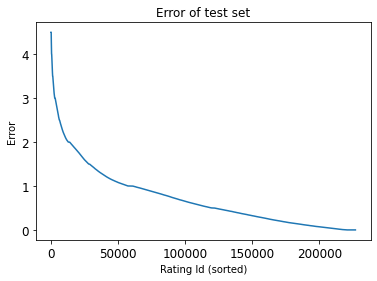

In [ ]:
# plot error of test set
ax = test['error'] \
    .sort_values(ascending=False) \
    .reset_index(drop=True) \
    .plot(
        title='Error of test set',
        fontsize=12
    )
ax.set_xlabel("Rating Id (sorted)")
# ax.axhline(y=threshold, color='r')
ax.set_ylabel("Error")

In [ ]:
test['error'].quantile(np.arange(1, 0, -0.1))

1.0    4.500000
0.9    1.679308
0.8    1.142590
0.7    0.939310
0.6    0.734554
0.5    0.543448
0.4    0.409863
0.3    0.271077
0.2    0.147298
0.1    0.054863
Name: error, dtype: float64

## Run with different knn values

In [ ]:
# Note that these code may take a lot of time
RMSEs = []
for knn in range(1, 10, 1):
  test['pred'] = test.apply(lambda row : predict(row.userId, row.movieId, knn), axis = 1)
  test['mse'] = (test['rating'] - test['pred']) ** 2
  mse = test['mse'].sum()/len(test)
  rmse = np.sqrt(mse)
  RMSEs.append([knn, rmse])

In [ ]:
RMSEs

Text(0, 0.5, 'RMSE')

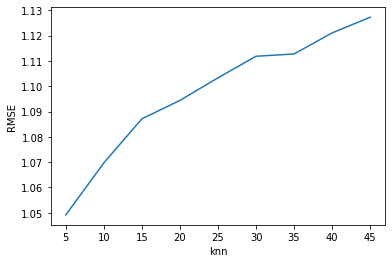

In [ ]:
RMSEs = np.array(RMSEs)
plt.plot(RMSEs[:,0], RMSEs[:,1])
plt.xlabel("knn")
plt.ylabel("RMSE")